In [1]:
##########################################################################
# Quantum Binary classifier using Keras
# Nikolaos Schetakis , nsxetakis@yahoo.gr 
# In this demo we plot the prediction grid for different number of blocks
###########################################################################

import pennylane as qml
import tensorflow as tf
from pennylane import numpy as np

N=450#NUMBER OF SAMPLES
noise=0.01 # applicable for moon and circle datasets
test_size=0.15 #training - test split

n_qubits = 2
layers = 2
epochsh = 15
batch_size = 20


np.random.seed(42)

learning_rate = 0.2 #for optimizer

In [2]:
from sklearn.datasets import make_moons , make_circles

# This part of the code is similar to the one written by Adrián Pérez-Salinas, Alba Cervera-Lierta, Elies Gil-Fuster, and José I. Latorre.
# https://github.com/AdrianPerezSalinas/universal_qlassifier/blob/master/data_gen.py
# Make a dataset of points inside and outside of a circle
def _circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)


def _squares(samples):
    data=[]
    Xvals, yvals = [], []
    dim=2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[0] < 0 and x[1] < 0: y = 0
        if x[0] < 0 and x[1] > 0: y = 1
        if x[0] > 0 and x[1] < 0: y = 1
        if x[0] > 0 and x[1] > 0: y = 0        
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)  
    



    
def _wavy_lines0(samples, freq = 1):
    Xvals, yvals = [], []
    def fun1(s):
        return s + np.sin(freq * np.pi * s)
    
    def fun2(s):
        return -s + np.sin(freq * np.pi * s)
    data=[]
    dim=2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[1] < fun1(x[0]) and x[1] < fun2(x[0]): y = 0
        if x[1] < fun1(x[0]) and x[1] > fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] < fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] > fun2(x[0]): y = 0        
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)
      
    
def _wavy_lines1(samples, freq = 1):
    Xvals, yvals = [], []
    def fun1(s):
        return s + np.sin(freq * np.pi * s)
    
    def fun2(s):
        return -s + np.sin(freq * np.pi * s)
    data=[]
    dim=2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[1] < fun1(x[0]) and x[1] < fun2(x[0]): y = 0
        if x[1] < fun1(x[0]) and x[1] > fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] < fun2(x[0]): y = 0
        if x[1] > fun1(x[0]) and x[1] > fun2(x[0]): y = 1        
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)
       

def _wavy_lines2(samples, freq = 1):
    Xvals, yvals = [], []
    def fun1(s):
        return s + np.sin(freq * np.pi * s)
    
    def fun2(s):
        return -s + np.sin(freq * np.pi * s)
    data=[]
    dim=2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[1] < fun1(x[0]) and x[1] < fun2(x[0]): y = 0
        if x[1] < fun1(x[0]) and x[1] > fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] < fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] > fun2(x[0]): y = 1        
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)
       
    
    
def _threecircles(samples):
    Xvals, yvals = [], []
    centers = np.array([[-1, 1], [1, 0], [-.5, -.5]])
    radii = np.array([1, np.sqrt(6/np.pi - 1), 1/2]) 
    data=[]
    dim = 2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        y = 0
        for j, (c, r) in enumerate(zip(centers, radii)): 
            if np.linalg.norm(x - c) < r:
                y = j + 1 
                
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)   
    
    
def _non_convex(samples, freq = 1, x_val = 2, sin_val = 1.5):
    Xvals, yvals = [], []
    def fun(s):
        return -x_val * s + sin_val * np.sin(freq * np.pi * s)
    
    data = []
    dim = 2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[1] < fun(x[0]): y = 0
        if x[1] > fun(x[0]): y = 1
        data.append([x, y])

        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)
    
    

def _crown(samples):
    Xvals, yvals = [], []
    c = [[0,0],[0,0]]
    r = [np.sqrt(.8), np.sqrt(.8 - 2/np.pi)]
    data = []
    dim = 2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if np.linalg.norm(x - c[0]) < r[0] and np.linalg.norm(x - c[1]) > r[1]:
            y = 1
        else: 
            y=0
        data.append([x, y])
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)


def _circle2(samples):
    Xvals, yvals = [], []
    centers = [[0,0],[0,0]]
    radii = [np.sqrt(.8 - 2/np.pi), np.sqrt(.8)]
    data = []
    dim = 2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        y=0
        for j,(r,c) in enumerate(zip(radii, centers)):
            if np.linalg.norm(x - c) > r:
                y = j + 1
        data.append([x, y])
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)



In [3]:
problems = ['circle', 'squares', 'wavy_lines0', 'wavy_lines1', 'wavy_lines2',
            'non convex', 'crown',  'squares',  'circle2']


def data_generator(problem, samples=None):
    """
    This function generates the data for a problem
    """
    
    if problem not in problems:
        raise ValueError('problem must be one of {}'.format(problems))

    if problem == 'circle':
        X, y = _circle(samples)
        
    if problem == '3 circles':
        X, y = _3_circles(samples)
        
    if problem == 'wavy_lines0':
        X, y = _wavy_lines0(samples)
        
    if problem == 'wavy_lines1':
        X, y = _wavy_lines1(samples)
        
    if problem == 'wavy_lines2':
        X, y = _wavy_lines2(samples)
        
    if problem == 'squares':
        X, y = _squares(samples)
        
    if problem == 'sphere':
        X, y = _sphere(samples)
        
    if problem == 'non convex':
        X, y = _non_convex(samples)
        
    if problem == 'crown':
        X, y = _crown(samples)
        
    if problem == 'circle2':
        X, y = _tricrown(samples)
        
    if problem == 'hypersphere':
        X, y = _hypersphere(samples)
    
        
    return X, y     
        
        


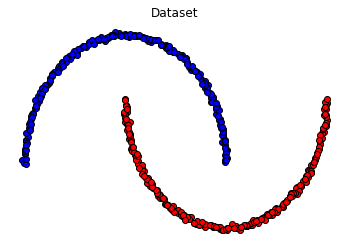

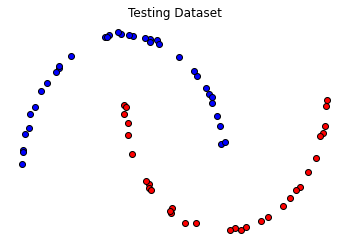

In [4]:
#-------------------------
# CHOOSE A DATASET , uncomment to select
#-------------------------
#X,y = data_generator("circle", N)
#X,y = data_generator("circle2", N)
#X,y = data_generator("non convex", N)
#X,y = data_generator("squares", N)
#X,y = data_generator("squares", N)
#X,y = data_generator("wavy_lines2", N)
#X,y = data_generator("crown", N)
#X, y = make_circles(n_samples=N, noise=noise)
X, y = make_moons(n_samples=N, noise=noise)

#-------------------------
#-------------------------


#Normalize from -pi to pi
from sklearn.preprocessing import StandardScaler , minmax_scale
X = minmax_scale(X, feature_range=(-np.pi, np.pi))

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], c="r", marker="o", edgecolors="k")
plt.title("Dataset")
plt.axis('off')
plt.show()

#train/test split and pre-processing
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

plt.figure()
plt.scatter(X_test[:, 0][y_test == 0], X_test[:, 1][y_test == 0], c="b", marker="o", edgecolors="k")
plt.scatter(X_test[:, 0][y_test == 1], X_test[:, 1][y_test == 1], c="r", marker="o", edgecolors="k")
plt.title("Testing Dataset")
plt.axis('off')
plt.show()

---------------------------------
block =  1
---------------------------------
Epoch 1/15
20/20 [==============================] - 9s 433ms/step - loss: 0.2647 - accuracy: 0.5105 - val_loss: 0.2560 - val_accuracy: 0.5735
Epoch 2/15
20/20 [==============================] - 9s 443ms/step - loss: 0.2588 - accuracy: 0.5236 - val_loss: 0.2533 - val_accuracy: 0.6176
Epoch 3/15
20/20 [==============================] - 9s 472ms/step - loss: 0.2540 - accuracy: 0.5576 - val_loss: 0.2500 - val_accuracy: 0.6324
Epoch 4/15
20/20 [==============================] - 9s 439ms/step - loss: 0.2504 - accuracy: 0.5524 - val_loss: 0.2477 - val_accuracy: 0.6471
Epoch 5/15
20/20 [==============================] - 9s 456ms/step - loss: 0.2460 - accuracy: 0.5733 - val_loss: 0.2423 - val_accuracy: 0.6618
Epoch 6/15
20/20 [==============================] - 11s 528ms/step - loss: 0.2377 - accuracy: 0.6387 - val_loss: 0.2308 - val_accuracy: 0.6029
Epoch 7/15
20/20 [==============================] - 9s 466ms/step - 

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


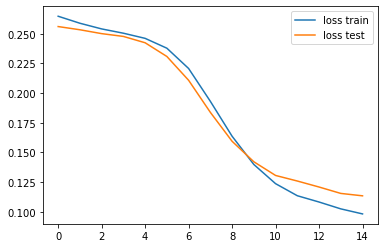

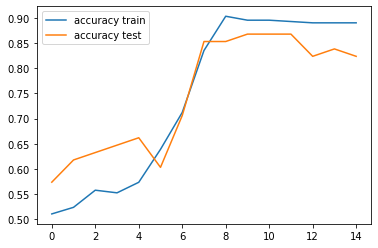

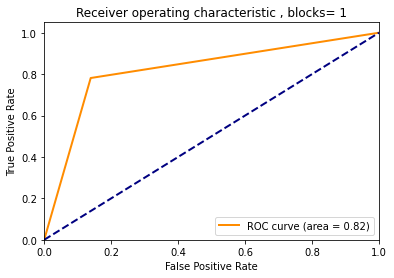

---------------------------------
block =  2
---------------------------------
Epoch 1/15
20/20 [==============================] - 17s 836ms/step - loss: 0.2583 - accuracy: 0.4921 - val_loss: 0.2487 - val_accuracy: 0.5294
Epoch 2/15
20/20 [==============================] - 18s 923ms/step - loss: 0.2472 - accuracy: 0.5759 - val_loss: 0.2376 - val_accuracy: 0.6176
Epoch 3/15
20/20 [==============================] - 17s 834ms/step - loss: 0.2350 - accuracy: 0.6257 - val_loss: 0.2271 - val_accuracy: 0.6324
Epoch 4/15
20/20 [==============================] - 17s 832ms/step - loss: 0.2230 - accuracy: 0.6623 - val_loss: 0.2151 - val_accuracy: 0.6324
Epoch 5/15
20/20 [==============================] - 17s 833ms/step - loss: 0.2081 - accuracy: 0.6806 - val_loss: 0.2022 - val_accuracy: 0.6618
Epoch 6/15
20/20 [==============================] - 18s 924ms/step - loss: 0.1924 - accuracy: 0.7173 - val_loss: 0.1868 - val_accuracy: 0.7059
Epoch 7/15
20/20 [==============================] - 17s 861ms/s

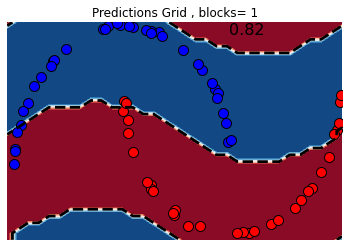

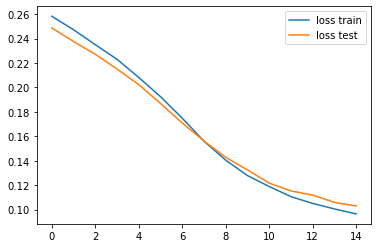

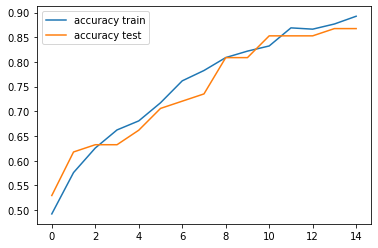

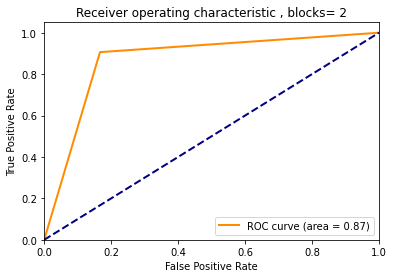

---------------------------------
block =  3
---------------------------------
Epoch 1/15
20/20 [==============================] - 24s 1s/step - loss: 0.2082 - accuracy: 0.6859 - val_loss: 0.1820 - val_accuracy: 0.7941
Epoch 2/15
20/20 [==============================] - 24s 1s/step - loss: 0.1705 - accuracy: 0.8063 - val_loss: 0.1560 - val_accuracy: 0.8382
Epoch 3/15
20/20 [==============================] - 24s 1s/step - loss: 0.1476 - accuracy: 0.8325 - val_loss: 0.1400 - val_accuracy: 0.8824
Epoch 4/15
20/20 [==============================] - 24s 1s/step - loss: 0.1294 - accuracy: 0.8901 - val_loss: 0.1253 - val_accuracy: 0.8824
Epoch 5/15
20/20 [==============================] - 24s 1s/step - loss: 0.1147 - accuracy: 0.8901 - val_loss: 0.1157 - val_accuracy: 0.8529
Epoch 6/15
20/20 [==============================] - 24s 1s/step - loss: 0.1019 - accuracy: 0.8953 - val_loss: 0.1065 - val_accuracy: 0.8529
Epoch 7/15
20/20 [==============================] - 27s 1s/step - loss: 0.0914 - 

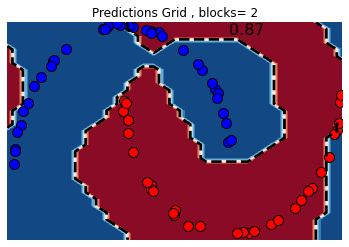

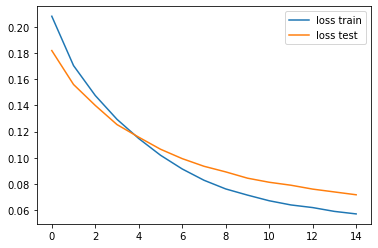

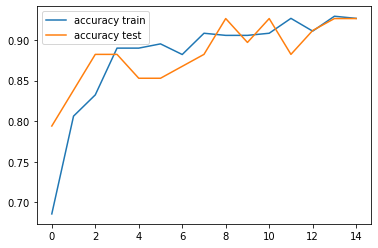

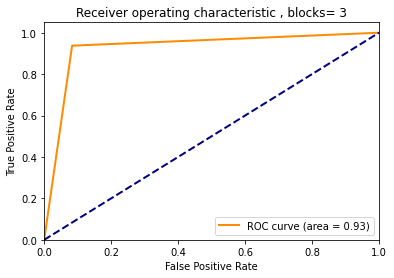

---------------------------------
block =  4
---------------------------------
Epoch 1/15
20/20 [==============================] - 31s 2s/step - loss: 0.2330 - accuracy: 0.5890 - val_loss: 0.2044 - val_accuracy: 0.8088
Epoch 2/15
20/20 [==============================] - 32s 2s/step - loss: 0.1904 - accuracy: 0.8194 - val_loss: 0.1733 - val_accuracy: 0.8824
Epoch 3/15
20/20 [==============================] - 32s 2s/step - loss: 0.1590 - accuracy: 0.9110 - val_loss: 0.1492 - val_accuracy: 0.9118
Epoch 4/15
20/20 [==============================] - 34s 2s/step - loss: 0.1350 - accuracy: 0.9267 - val_loss: 0.1320 - val_accuracy: 0.9118
Epoch 5/15
20/20 [==============================] - 32s 2s/step - loss: 0.1168 - accuracy: 0.9293 - val_loss: 0.1194 - val_accuracy: 0.9118
Epoch 6/15
20/20 [==============================] - 31s 2s/step - loss: 0.1029 - accuracy: 0.9241 - val_loss: 0.1104 - val_accuracy: 0.9118
Epoch 7/15
20/20 [==============================] - 33s 2s/step - loss: 0.0927 - 

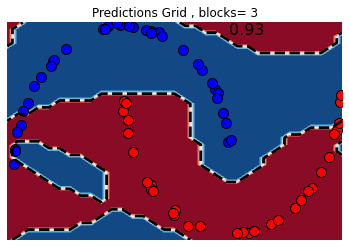

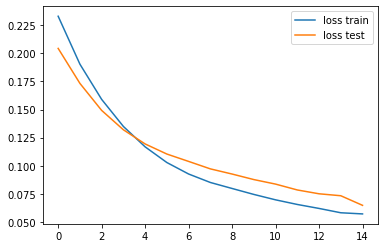

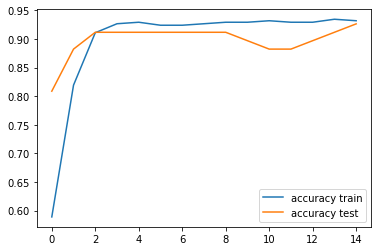

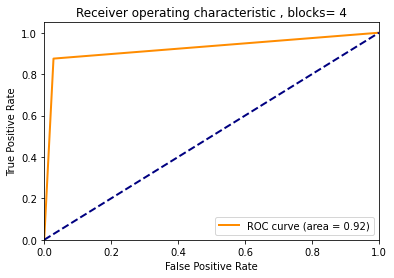

---------------------------------
block =  5
---------------------------------
Epoch 1/15
20/20 [==============================] - 47s 2s/step - loss: 0.2580 - accuracy: 0.4712 - val_loss: 0.2462 - val_accuracy: 0.5735
Epoch 2/15
20/20 [==============================] - 48s 2s/step - loss: 0.2418 - accuracy: 0.6257 - val_loss: 0.2290 - val_accuracy: 0.6912
Epoch 3/15
20/20 [==============================] - 48s 2s/step - loss: 0.2204 - accuracy: 0.7723 - val_loss: 0.1984 - val_accuracy: 0.7941
Epoch 4/15
20/20 [==============================] - 49s 2s/step - loss: 0.1849 - accuracy: 0.8298 - val_loss: 0.1614 - val_accuracy: 0.8382
Epoch 5/15
20/20 [==============================] - 45s 2s/step - loss: 0.1500 - accuracy: 0.8796 - val_loss: 0.1338 - val_accuracy: 0.8824
Epoch 6/15
20/20 [==============================] - 40s 2s/step - loss: 0.1243 - accuracy: 0.9031 - val_loss: 0.1160 - val_accuracy: 0.8824
Epoch 7/15
20/20 [==============================] - 42s 2s/step - loss: 0.1053 - 

In [ ]:
from sklearn.metrics import roc_auc_score
from numpy import arange
from numpy import meshgrid
from numpy import hstack
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import roc_auc_score
qml.enable_tape()
dev = qml.device("default.qubit.tf", wires=n_qubits)
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=10, verbose=1)

@qml.qnode(dev, interface="tf", grad_method="backprop")
def qnode(inputs, weights):
    for i in range(blocks):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights[i], wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]



maxn=7
for x in range(1,maxn+1):
    blocks=x
    print("---------------------------------")
    print("block = ",blocks)
    print("---------------------------------")
    #layers_per_block = 1
    weights_shape = (blocks, layers, n_qubits, 3)
    weights = tf.Variable(np.random.random(weights_shape))
    inputs = tf.constant(np.random.random(n_qubits))
    #print("Output of QNode:", qnode(inputs, weights).numpy())
    # Optionally convert to Keras layer:
    tf.keras.backend.set_floatx("float64")
    weight_shapes = {"weights": weights_shape}
    qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, n_qubits)
    clayerf = tf.keras.layers.Dense(1, activation="sigmoid")
    inputs = tf.constant(np.random.random((batch_size, n_qubits)))
    #print("Output of quantum layer:\n", qlayer(inputs).numpy())
    modelh = tf.keras.models.Sequential([qlayer,clayerf])
    modelh.compile(opt, loss='mse',metrics=['accuracy'])
    historyh = modelh.fit(X_train, y_train,validation_data=(X_test, y_test), callbacks=[es], epochs=epochsh, batch_size=batch_size)
    # Make predictions on X_test
    y_pred = modelh.predict_classes(X_test)
    #---------------------- Confusion matrix ----------------------
    confusion_matrix(y_test, y_pred)
    #---------------------- History plot ----------------------
    pyplot.plot(historyh.history['loss'], label='loss train')
    pyplot.plot(historyh.history['val_loss'], label='loss test')
    pyplot.legend()
    pyplot.show()
    pyplot.plot(historyh.history['accuracy'], label='accuracy train')
    pyplot.plot(historyh.history['val_accuracy'], label='accuracy test')
    pyplot.legend()
    #---------------------- Auc Roc ----------------------
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(y_test)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic , blocks= ' +str(blocks))
    plt.legend(loc="lower right")
    plt.show()
    #---------------------- PREDICTION GRID PLOT ----------------------
    
    min1, max1 = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    min2, max2 = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    x1grid = arange(min1, max1, 0.2)
    x2grid = arange(min2, max2, 0.2)
    xx, yy = meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = hstack((r1,r2))

    # make predictions for the grid
    yhat = modelh.predict_classes(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)

    # plot decision regions
    plt.contour(xx, yy,zz, levels=[0.5], colors=("black",), linestyles=("--",), linewidths=(2.8,))
    cnt = pyplot.contourf(xx, yy, zz, cmap='RdBu_r',levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1])
    plt.title("Predictions Grid , blocks= "+str(blocks))
    plt.scatter(
    X_test[:, 0][y_test == 0],
    X_test[:, 1][y_test == 0],
    c="b",s=100,
    marker="o",
    edgecolors="k",
    label="class 0 test ",
    )

    plt.scatter(
    X_test[:, 0][y_test == 1],
    X_test[:, 1][y_test == 1],
    c="r",s=100,
    marker="o",
    edgecolors="k",
    label="class 1 test",
    )
    plt.axis('off')
    plt.text(1,2.8,round(roc_auc_score(y_test,y_pred),2), fontsize=16)
    plt.figure()
    plt.show
    #plt.text(1,2.8,round(roc_auc[2],2), fontsize=24)
    #plt.colorbar(cnt, ticks=[0, 0.5, 1])